Made to repractice old KNOWLEDGE.

Heavily inspired from first part of https://karpathy.ai/zero-to-hero.html.

In [1]:
#!pip install numpy
#!pip install graphviz

In [2]:
import math

class Value:
    def __init__(self, data, _children=(), grad=0.0, _op="", label=""):
        self.data = float(data)
        self._prev = set(_children)
        self.grad = grad # https://en.wikipedia.org/wiki/Gradient
        self._backward = lambda: None # https://en.wikipedia.org/wiki/Backpropagation
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data=%.4f)" % self.data

    def __str__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = Value._assert(other)
        ret = Value(self.data + other.data, _children=(self, other), _op="+")
        def _backward():
            self.grad += 1.0 * ret.grad
            other.grad += 1.0 * ret.grad
        ret._backward = _backward
        return ret
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self, other):
        other = Value._assert(other)
        ret = Value(self.data * other.data, _children=(self, other), _op="*")
        def _backward():
            self.grad += other.data * ret.grad
            other.grad += self.data * ret.grad
        ret._backward = _backward
        return ret

    def __rmul_(self, other):
        return self.__mul__(other)

    def __pow__(self, other):
        #other = Value._assert(other)
        assert isinstance(other, (int, float))
        ret = Value(self.data**other, _children=(self,), _op=f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * ret.grad
        ret._backward = _backward
        return ret

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def exp(self):
        ret = Value(math.exp(self.data), _children=(self,), _op='exp')
        def _backward():
              self.grad += ret.data * ret.grad
        ret._backward = _backward
        return ret

    # activation funtion
    def tanh(self):
        t = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
        ret = Value(t, _children=(self,), _op='tanh')
        def backward():
            self.grad += (1 - t**2) * ret.grad
        ret._backward = backward
        return ret
    
    def backward(self):
        # https://en.wikipedia.org/wiki/Topological_sorting
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    @staticmethod
    def _assert(ret):
        if isinstance(ret, Value):
            return ret
        elif isinstance(ret, (int, float)):
            return Value(ret)
        assert ValueError(f"Wrong input. Wanted type Value, int or float; not {type(ret)}")

In [3]:
from graphviz import Digraph

def trace(root):
    nodes = set()
    edges = set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

### Showcase of chainrule (backpropagation)

In [4]:
a = Value(2.0, label="a")
b = Value(3.0, label="b")
e = a*b; c.label = 'c'
e.backward()
draw_dot(c)

NameError: name 'c' is not defined

In [ ]:
a = Value(2.0, label="a")
b = Value(3.0, label="b")
c = a*b; c.label = 'c'
d = Value(4.0, label="d")
e = c*d; e.label = "e"
e.backward()
draw_dot(e)

$$
\frac{de}{da} = \frac{de}{dc} * \frac{dc}{de}
$$
$$
\text{Derivation of multiplication is swapping gradients and of addition is passing the gradient one before.}
$$

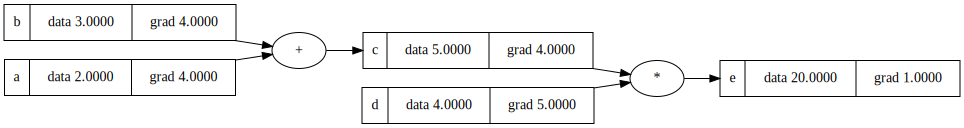

In [5]:
a = Value(2.0, label="a")
b = Value(3.0, label="b")
c = a+b; c.label = 'c'
d = Value(4.0, label="d")
e = c*d; e.label = "e"
e.backward()
draw_dot(e)

In [6]:
x1 = Value(0.0, label='x1')
x2 = Value(3.0, label='x2')
w1 = Value(2.0, label='w1')
w2 = Value(-0.9, label='w2')
a = Value(2.2, label='a')
b = Value(3.14, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x2w2a = x2w2+a ; x2w2a.label = 'x2w2a'
x1w1x2w2a = x1w1 + x2w2a; x1w1x2w2a.label = 'x1*w1 + x2*w2a'
n = x1w1x2w2a * b; n.label = 'n'
#o = n.tanh(); o.label = 'o'
n.backward()

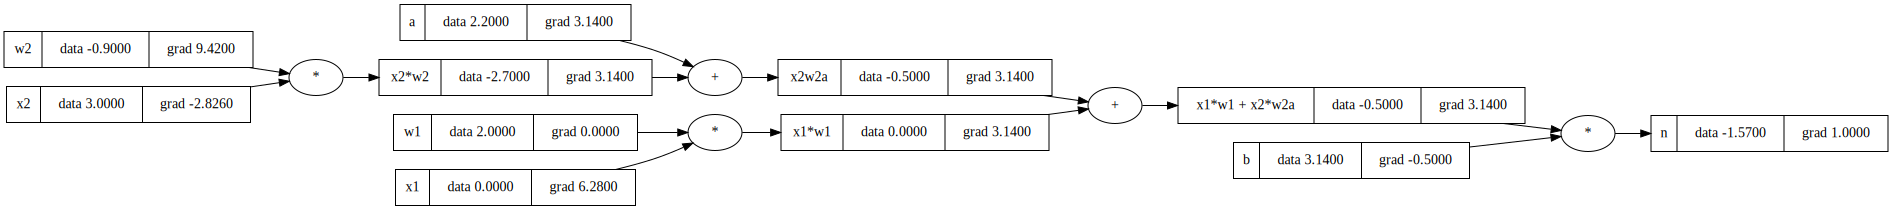

In [7]:
draw_dot(n)

$$
\frac{dn}{dw2} = \frac{dn}{x2w2} * \frac{x2w2}{dw2} = \frac{dn}{x2w2a} * \frac{x2w2a}{x2w2} * \frac{x2w2}{dw2} = \frac{dn}{x1w1x2w2a} * \frac{x1w1x2w2a}{x2w2a} * \frac{x2w2a}{x2w2} * \frac{x2w2}{dw2}
$$

In [8]:
from random import uniform

class Neuron:
    def __init__(self, n):
        self.weights = [Value(uniform(-1, 1)) for _ in range(n)]
        self.bias = Value(uniform(-1, 1))
    
    def __repr__(self):
        return f"Neuron(w=[{self.weights}], b={self.bias})"
    
    def __str__(self):
        return f"{self.weights}"

    def __matmul__(self, x):
        ret = sum((wi*xi for wi, xi in zip(self.weights, x))) + self.bias
        ret =  ret.tanh() # act_fn
        return ret

    def parameters(self):
        return self.weights + [self.bias] # [w1, w2, ..., wn, b]
    
class Layer:
    """
    Layer class represents matrix (list of list) of Neurons (list) with a size NxL, 
    but each column is in code row (no transpose).
    """
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __repr__(self):
        ret = ""
        for i in self.neurons:
            ret += ' '*5 + str(i)
            ret += ';\n'
        return ret
    
    def __str__(self):
        return self.__repr__()
    
    def __call__(self, x):
        #return [n @ x for n in self.neurons]
        ret = [n @ x for n in self.neurons]
        return ret[0] if len(ret) == 1 else ret

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, n_in, n_out):
        assert isinstance(n_out, (list, tuple))
        size = [n_in] + n_out # [n_in, n_out1, n_out2, ..., n_outn]
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_out))]
    
    def __repr__(self):
        ret = ""
        for i in range(len(self.layers)):
            ret += f'Layer_{i} of size {len(self.layers[i].neurons)}x{len(self.layers[i].neurons[0].weights)}'+'\n'
            ret += str(self.layers[i])
            ret += '\n'
        return ret
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
def loss_fn(target, prediction): # vector of any size --> to scalar for backward-propagation
    # mean square
    return sum((y_out - y_gt)**2 for y_gt, y_out in zip(target, prediction))

In [10]:
# 4 inputs
_inputs = [
  [1.0, 2.1, 3.0],
  [3.0, -1.0, 0.1],
  [0.8, -5.0, -2.5],
  [0.1, 4.0, -1.0],
]
# wanted 4 results
target = [1.0, -1.0, -1.0, 1.0]
#training_data = ((i, j) for i, j in zip(_inputs, target))
n = MLP(3, [4, 4, 1])

In [11]:
n

Layer_0 of size 4x3
     [Value(data=-0.7983), Value(data=0.6572), Value(data=0.1626)];
     [Value(data=0.9289), Value(data=0.8817), Value(data=-0.5582)];
     [Value(data=-0.7793), Value(data=0.0170), Value(data=-0.5538)];
     [Value(data=-0.2298), Value(data=0.3611), Value(data=-0.4781)];

Layer_1 of size 4x4
     [Value(data=-0.8681), Value(data=-0.5374), Value(data=0.5662), Value(data=-0.4032)];
     [Value(data=0.4459), Value(data=-0.1313), Value(data=-0.0857), Value(data=-0.6660)];
     [Value(data=0.4263), Value(data=0.1734), Value(data=0.4615), Value(data=-0.4365)];
     [Value(data=0.5824), Value(data=-0.5207), Value(data=0.1505), Value(data=-0.6425)];

Layer_2 of size 1x4
     [Value(data=-0.9152), Value(data=-0.9400), Value(data=-0.5183), Value(data=-0.0719)];


In [12]:
# training loop
for k in range(101):  
    # forward pass
    predictions = [n(_in) for _in in _inputs]
    loss = loss_fn(target, predictions)
    
    # backward pass
    for p in n.parameters(): # reset gradients
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
  
    if k % 10 == 0:
        print(k, loss)

0 Value(6.980742912036781)
10 Value(0.015566762572422666)
20 Value(0.009110736151747227)
30 Value(0.006614475721536706)
40 Value(0.005230299052759926)
50 Value(0.00433527013292245)
60 Value(0.003704305066816205)
70 Value(0.003233866016596519)
80 Value(0.0028689366853548014)
90 Value(0.002577322502981957)
100 Value(0.0023388296934453304)


In [13]:
idx = 0
print(f'Input: {_inputs[idx]} | Target: {target[idx]} | Output: {n(_inputs[idx])}')

Input: [1.0, 2.1, 3.0] | Target: 1.0 | Output: Value(0.9733058031288749)


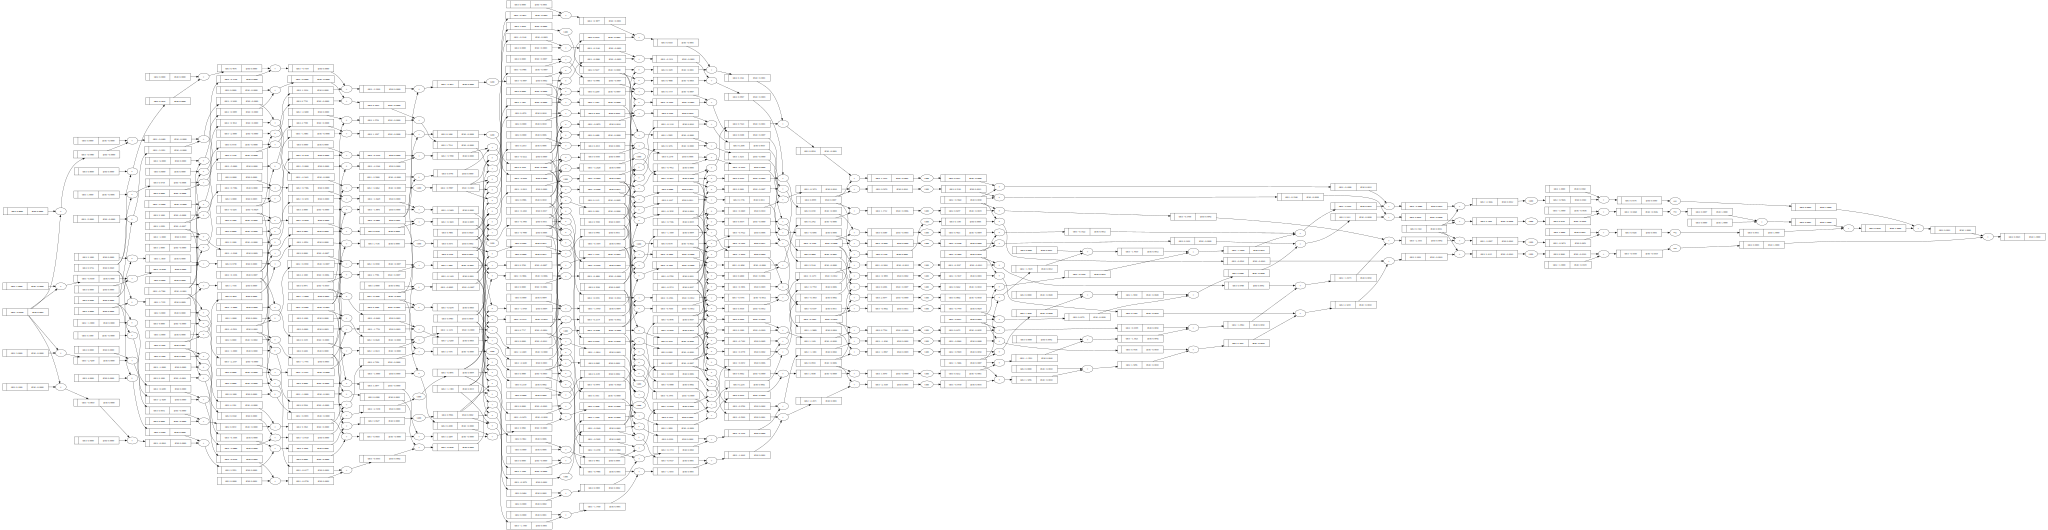

In [14]:
draw_dot(loss)